<a href="https://colab.research.google.com/github/Zfeng0207/FIT3199-FYP/blob/dev%2Fzfeng/lstm_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starting the Notebook



## Loading Dependencies

In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main')

In [101]:
# !pip install -qqqq mlflow torchmetrics pytorch_lightning

In [102]:
import mlflow

In [103]:
memmap_meta_path = "src/data/memmap/memmap_meta.npz"
memmap_path = "src/data/memmap/memmap.npy"
df_diag_path = "src/data/records_w_diag_icd10.csv"
df_memmap_pkl_path = "src/data/memmap/df_memmap.pkl"


## Merge dataset with labels and ecg paths

In [104]:
import pandas as pd

df_diag = pd.read_csv(df_diag_path)
df_mapped = pd.read_pickle(df_memmap_pkl_path)

In [105]:
# merged_df = pd.merge(df_pkl, df_mapped, on=["study_id"], how="left")

## Labeling stroke classes

In [106]:
df_labels = df_diag['label_test'].apply(lambda x: 0 if x == '[]' else 1).to_frame(name='Stroke_YN')

In [107]:
df_labels.to_csv("src/data/labels.csv")

In [108]:
df_labels = pd.read_csv("src/data/labels.csv")

## Visualizing target class distribution

In [109]:
# Count the occurrences of each target class
target_counts = df_labels['Stroke_YN'].value_counts()
print(target_counts)

Stroke_YN
0    782005
1     18030
Name: count, dtype: int64


<ipython-input-110-33e75e129976>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")


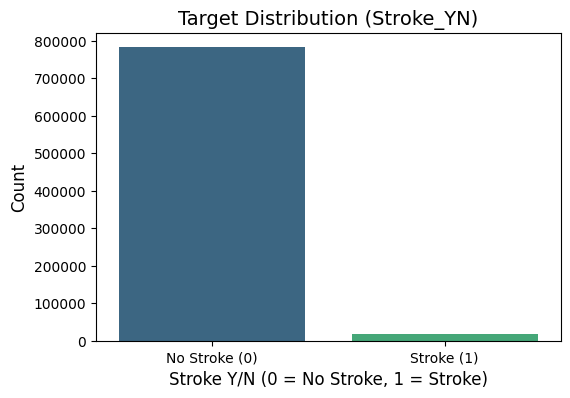

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")
plt.title("Target Distribution (Stroke_YN)", fontsize=14)
plt.xlabel("Stroke Y/N (0 = No Stroke, 1 = Stroke)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], labels=["No Stroke (0)", "Stroke (1)"])
plt.show()

## Data Class

In [111]:
import torch
from torch.utils.data import Dataset

class ECGDataset(Dataset):
    def __init__(self, memmap, labels_df):
        self.df = labels_df
        self.memmap = memmap

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      # Access data directly from the DataFrame
      start = self.df.loc[idx, 'start']
      length = self.df.loc[idx, 'length']
      # file_idx = self.df.loc[idx, 'file_idx'] # You might not need file_idx here anymore

      # Extract the flat signal slice
      signal = self.memmap[start : start + length * 12]  # 12 features per timestep
      signal = (signal - signal.mean(axis=0)) / (signal.std(axis=0) + 1e-6)

      # Reshape to [length, 12]
      signal = signal.reshape(length, 12)

      # Convert signal to PyTorch tensor before checking for NaN/inf
      signal = torch.tensor(signal, dtype=torch.float32)

      if torch.isnan(signal).any() or torch.isinf(signal).any():
        return None

      label = self.df.loc[idx, 'Stroke_YN']  # Access label from DataFrame
      return signal, torch.tensor(label, dtype=torch.long) # signal is already a tensor


In [112]:
from torch.nn.utils.rnn import pad_sequence
def safe_collate(batch):
    # Filter out None entries
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None  # Skip entire batch if empty (optional, or raise Exception)

    signals, labels = zip(*batch)
    signals = pad_sequence(signals, batch_first=True)  # if variable-length ECG
    labels = torch.tensor(labels)
    return signals, labels


In [113]:
from torch.utils.data import DataLoader
import pytorch_lightning as pl

class ECGDataModule(pl.LightningDataModule):
    def __init__(self, memmap, train_df, val_df, test_df, batch_size=32):
        super().__init__()
        self.memmap = memmap
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = ECGDataset(self.memmap, self.train_df)
        self.val_dataset = ECGDataset(self.memmap, self.val_df)
        self.test_dataset = ECGDataset(self.memmap, self.test_df)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=11, collate_fn=safe_collate, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,  num_workers=11, collate_fn=safe_collate, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=11, collate_fn=safe_collate, pin_memory=True)


# Simple LSTM Model

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torchmetrics.classification import BinaryF1Score, BinaryAUROC


class LSTMSleepClassifier(pl.LightningModule):
    def __init__(self, input_size=12, hidden_size=64, num_layers=2, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.train_f1 = BinaryF1Score()
        self.val_f1 = BinaryF1Score()
        self.test_f1 = BinaryF1Score()

        self.train_auc = BinaryAUROC()
        self.val_auc = BinaryAUROC()
        self.test_auc = BinaryAUROC()

        self.fc = nn.Linear(hidden_size * 2, 1)  # bidirectional
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).to(self.device))

    def forward(self, x):
        # x: (B, T, C) → needs to be (B, T, 12)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last timestep
        logits = self.fc(out)
        return logits.squeeze()

    def training_step(self, batch, batch_idx):
        self.train()
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        probs = torch.sigmoid(logits)
        preds = probs > 0.5
        auc = self.train_auc(probs, y.int())
        acc = (preds == y).float().mean()
        f1 = self.train_f1(preds, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        self.log("train_f1", f1, prog_bar=True)
        self.log("train_auc", auc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        probs = torch.sigmoid(logits)
        preds = probs > 0.5
        auc = self.train_auc(probs, y.int())
        acc = (preds == y).float().mean()
        f1 = self.val_f1(preds, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.log("val_f1", f1, prog_bar=True)
        self.log("val_auc", auc, prog_bar=True)

        return loss


    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        probs = torch.sigmoid(logits)
        preds = probs > 0.5
        auc = self.train_auc(probs, y.int())

        acc = (preds == y).float().mean()
        f1 = self.test_f1(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)
        self.log("test_auc", auc, prog_bar=True)

        return loss

    # def configure_gradient_clipping(
    #     self,
    #     optimizer=None,
    #     optimizer_idx=None,
    #     gradient_clip_val=None,
    #     gradient_clip_algorithm=None
    # ):
    #     if optimizer is not None:
    #         torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)



    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)  # Reduced lr


## Data Sampling

In [ ]:
import pandas as pd
import numpy as np

# Define paths
df_path = "src/data/df_memmap.csv"
train_df_path = "src/data/train_df.csv"
val_df_path = "src/data/val_df.csv"

# Check if all files exist
if os.path.exists(df_path) and os.path.exists(train_df_path) and os.path.exists(val_df_path):
  df = pd.read_csv(df_path)
  train_df = pd.read_csv(train_df_path)
  val_df = pd.read_csv(val_df_path)

else:
  memmap_data = np.memmap(memmap_path, dtype=np.float32, mode='r')
  # memmap_data = torch.tensor(memmap_data).to("cuda")
  meta = np.load(memmap_meta_path, allow_pickle=True)
  start = meta['start']
  length = meta['length']

  # Load labels CSV
  df = df_labels.copy()

  # Sanity check
  assert len(df) == len(start), "Mismatch between label and memmap metadata length"

  # Add metadata into DataFrame
  df['start'] = start
  df['length'] = length

  # Now you can split the DataFrame while keeping track of ECG data pointers
  from sklearn.model_selection import train_test_split

  # Split test set with preserved stroke ratio
  train_val_df, test_df = train_test_split(
      df, test_size=0.10, stratify=df['Stroke_YN'], random_state=42
  )

  # Then split stroke/non-stroke from train_val_df as discussed before
  stroke_df = train_val_df[train_val_df['Stroke_YN'] == 1]
  nonstroke_df = train_val_df[train_val_df['Stroke_YN'] == 0]

  # Balanced sampling
  train_stroke, val_stroke = train_test_split(stroke_df, test_size=0.1, random_state=42)
  train_nonstroke = nonstroke_df.sample(n=len(train_stroke)*2, random_state=42)
  val_nonstroke = nonstroke_df.drop(train_nonstroke.index).sample(n=len(val_stroke)*2, random_state=42)

  # Final splits
  train_df = pd.concat([train_stroke, train_nonstroke]).reset_index(drop=True)
  val_df = pd.concat([val_stroke, val_nonstroke]).reset_index(drop=True)
  test_df = test_df.reset_index(drop=True)

  df.to_csv("src/data/df_memmap.csv", index=False)
  train_df.to_csv("src/data/train_df.csv", index=False)
  val_df.to_csv("src/data/val_df.csv", index=False)
  test_df.to_csv("src/data/test_df.csv", index=False)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

labels = train_df["Stroke_YN"].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=labels)

# class_weights[1] is the weight for positive class
pos_weight = class_weights[1] / class_weights[0]  # Convert to ratio


Model and data Initialization

In [ ]:
# Create the data module
ecg_dm = ECGDataModule(
    memmap=memmap_data,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    batch_size=64
)

In [ ]:
# Initialize model
model = LSTMSleepClassifier(input_size=12)

## Setting up Mlflow for model baseline tracking

## Model Training

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import MLFlowLogger
import mlflow

import mlflow
import mlflow.pytorch
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import os

os.environ['MLFLOW_TRACKING_USERNAME'] = "Zfeng0207"
os.environ['MLFLOW_TRACKING_PASSWORD'] = "af7c8365aec4d3ff7a40563a35ec94d4bc9b4512"
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = "stroke-prediction-dagshub-repo"
# Setup
experiment_name = "lstm-ecg"
tracking_uri = f"https://dagshub.com/{os.environ['MLFLOW_TRACKING_USERNAME']}/{os.environ['MLFLOW_TRACKING_PROJECTNAME']}.mlflow"

mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name)

print(f"MLflow tracking experiment name: {experiment_name}")
print(f"Tracking URI: {tracking_uri}")

# Use same URI in logger
mlf_logger = MLFlowLogger(
    experiment_name=experiment_name,
    tracking_uri=tracking_uri,
    log_model=True
)

2025/04/20 16:56:14 INFO mlflow.tracking.fluent: Experiment with name 'lstm-ecg' does not exist. Creating a new experiment.


MLflow tracking experiment name: lstm-ecg
Tracking URI: https://dagshub.com/Zfeng0207/stroke-prediction-dagshub-repo.mlflow


In [ ]:
trainer = Trainer(logger=mlf_logger, max_epochs=5,gradient_clip_val=1.0)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# trainer.fit(model, datamodule=ecg_dm)
# if mlflow.active_run() is not None:
#     mlflow.end_run()

## Evaluation Metrics

In [ ]:
import pandas as pd

# Create lists to hold signals and labels
signals = []
labels = []

for idx in range(len(df)):
    start = df.loc[idx, 'start']
    length = df.loc[idx, 'length']

    # Get and normalize the signal
    raw = memmap_data[start : start + length * 12]
    normed = (raw - raw.mean()) / (raw.std() + 1e-6)

    if np.isnan(normed).any() or np.isinf(normed).any():
        continue  # skip bad sample

    signal = normed.reshape(length, 12)
    signals.append(signal)
    labels.append(df.loc[idx, 'Stroke_YN'])

# Create DataFrame
df_signals = pd.DataFrame({
    "signal": signals,  # Each row is a 2D numpy array (object dtype)
    "label": labels
})

# RNN

In [116]:
!pip install -qqqq tensorflow

In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense


In [ ]:
X_train = train_df[['start', 'length']].values
y_train = train_df['Stroke_YN'].values

X_val = val_df[['start', 'length']].values
y_val = val_df['Stroke_YN'].values

In [120]:
def build_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(64))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))

    return model

In [121]:
rnn_model = build_rnn_model()

NameError: name 'X_train' is not defined

In [122]:
rnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

NameError: name 'rnn_model' is not defined

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=6,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              verbose=1,
                              patience=2,
                              min_lr=1e-6)

model_checkpoint = ModelCheckpoint('model.keras',
                                   monitor='val_loss',
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
rnn_history = rnn_model.fit(X_train_scaled, y_train,
                            epochs=10,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks= callbacks)

Epoch 1/10
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.8152 - loss: 0.7183 - val_accuracy: 0.8276 - val_loss: 0.6678 - learning_rate: 0.0010
Epoch 2/10
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 73s 26ms/step - accuracy: 0.8250 - loss: 0.6756 - val_accuracy: 0.8276 - val_loss: 0.6684 - learning_rate: 0.0010
Epoch 3/10
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 72s 26ms/step - accuracy: 0.8291 - loss: 0.6589 - val_accuracy: 0.8276 - val_loss: 0.6599 - learning_rate: 0.0010
Epoch 4/10
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 72s 26ms/step - accuracy: 0.8273 - loss: 0.6655 - val_accuracy: 0.8276 - val_loss: 0.6586 - learning_rate: 0.0010
Epoch 5/10
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 72s 26ms/step - accuracy: 0.8274 - loss: 0.6637 - val_accuracy: 0.8276 - val_loss: 0.6416 - learning_rate: 0.0010
Epoch 6/10
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 72s 26ms/step - accuracy: 0.8289 - loss: 0.6328 - val_accuracy: 0.8276 - val_loss: 0.6354 - learning_rate: 0.0010
Epoch 7/10
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 72s 26ms/step - accura

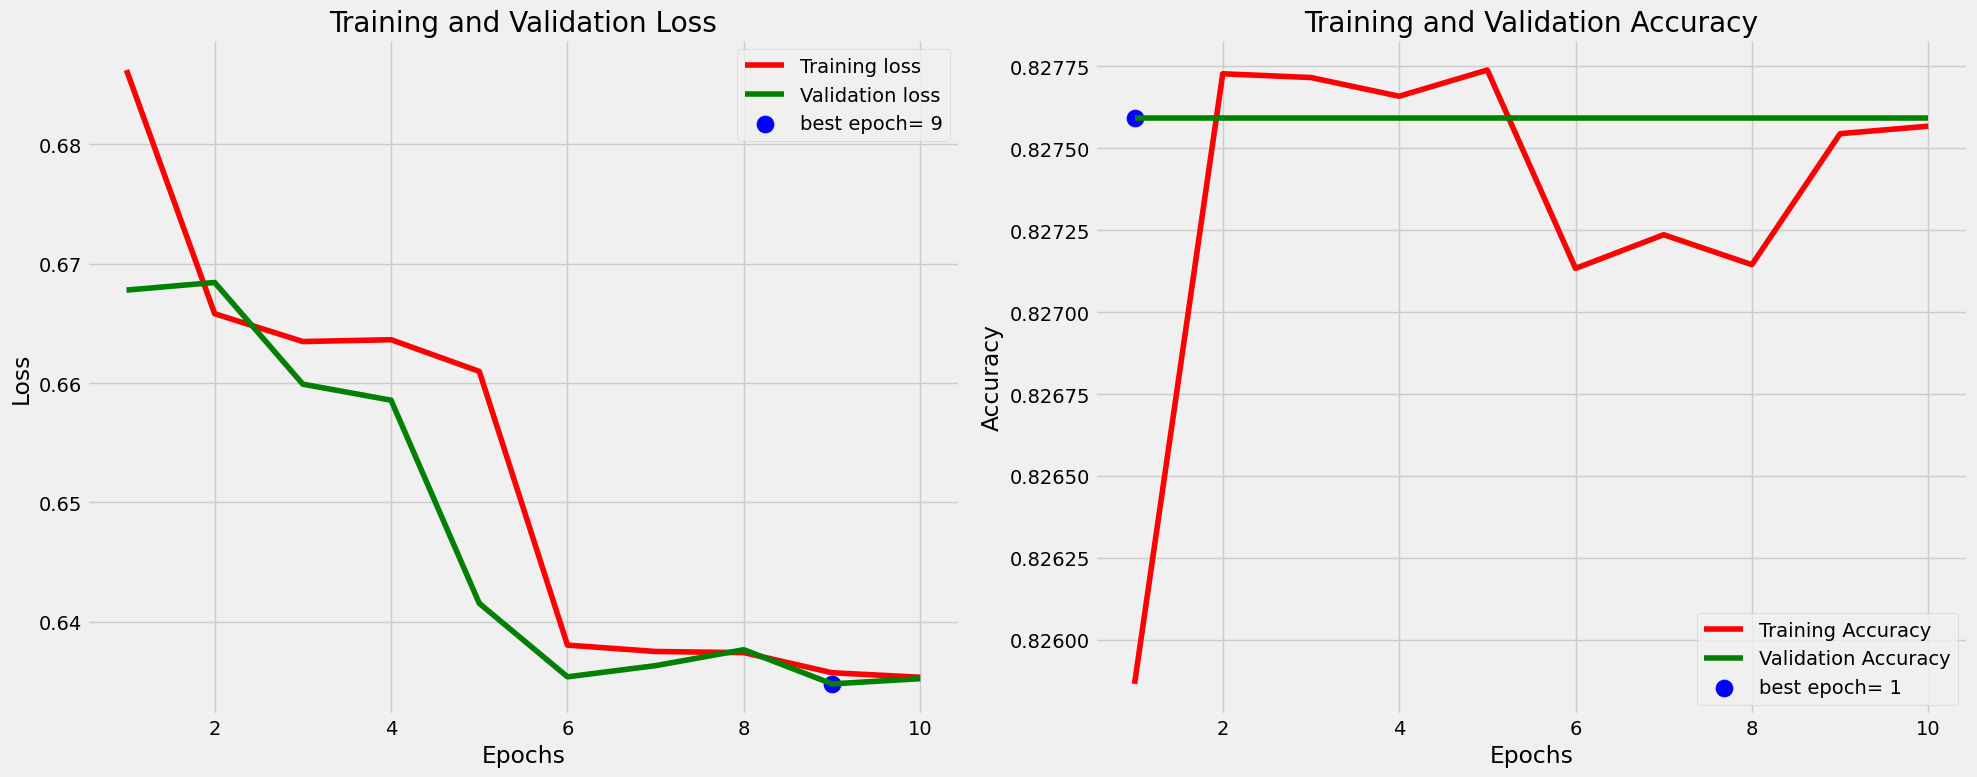

In [ ]:
learning_curves_plot(rnn_history, start_epoch=0)

In [ ]:
# Predict on the test set
y_test_pred_rnn = rnn_model.predict(X_test_new).argmax(axis=1)

343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [ ]:
# Evaluate RNN Model on Test Data
rnn_test_loss, rnn_test_acc = rnn_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"RNN Test Loss: {rnn_test_loss:.4f}")
print(f"RNN Test Accuracy: {rnn_test_acc:.4f}")

RNN Test Loss: 0.6309
RNN Test Accuracy: 0.8276


In [ ]:
# Classification report for RNN
print("RNN Classification Report:")
print(classification_report(y_test_new, y_test_pred_rnn))

RNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91      9059
         1.0       0.00      0.00      0.00       278
         2.0       0.00      0.00      0.00       724
         3.0       0.00      0.00      0.00        81
         4.0       0.00      0.00      0.00       804

    accuracy                           0.83     10946
   macro avg       0.17      0.20      0.18     10946
weighted avg       0.68      0.83      0.75     10946



In [ ]:
class_names = [labels[i] for i in range(len(labels))]

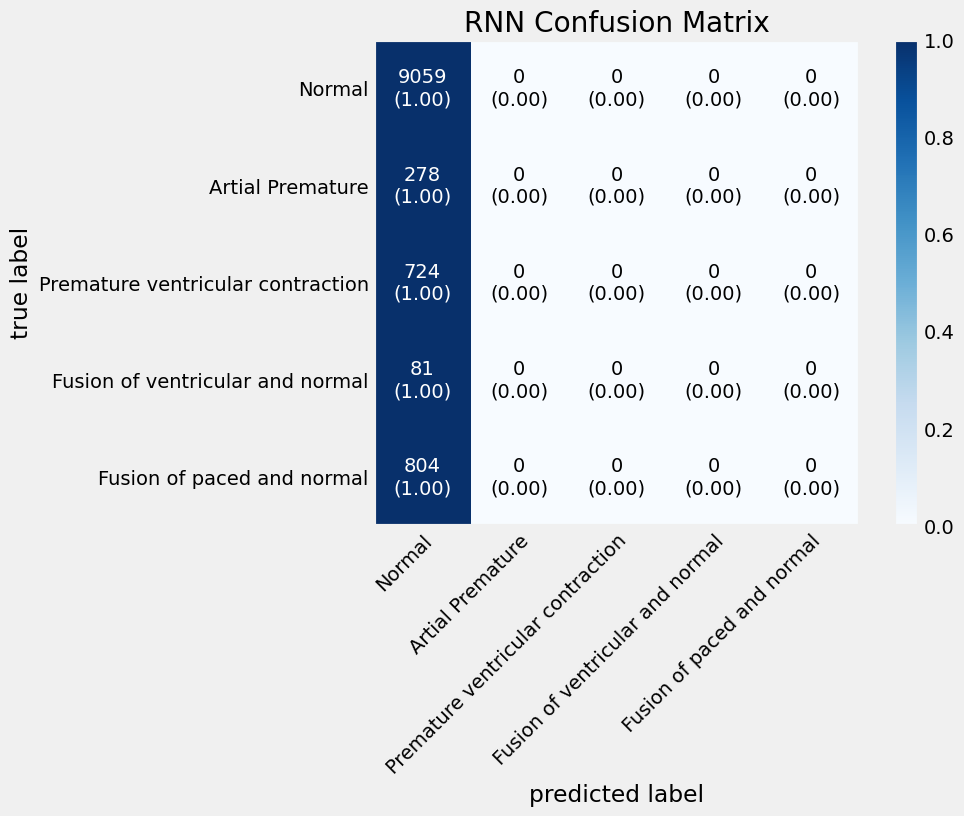

In [ ]:
# Confusion Matrix for RNN
conf_matrix_rnn = confusion_matrix(y_test_new, y_test_pred_rnn)

plot_confusion_matrix(conf_matrix_rnn,
                      class_names=class_names,
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.title('RNN Confusion Matrix')
plt.show()

# GRU

In [ ]:
def build_gru_model():
    model = Sequential()
    model.add(GRU(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(64))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))

    return model

In [ ]:
gru_model = build_gru_model()

In [ ]:
gru_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
gru_history = gru_model.fit(X_train_scaled, y_train,
                            epochs=20,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks= callbacks)

Epoch 1/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.8453 - loss: 0.5887 - val_accuracy: 0.9325 - val_loss: 0.2392 - learning_rate: 0.0010
Epoch 2/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - accuracy: 0.9428 - loss: 0.2139 - val_accuracy: 0.9589 - val_loss: 0.1622 - learning_rate: 0.0010
Epoch 3/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.9594 - loss: 0.1503 - val_accuracy: 0.9650 - val_loss: 0.1326 - learning_rate: 0.0010
Epoch 4/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.9660 - loss: 0.1258 - val_accuracy: 0.9698 - val_loss: 0.1098 - learning_rate: 0.0010
Epoch 5/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.9717 - loss: 0.1062 - val_accuracy: 0.9720 - val_loss: 0.1037 - learning_rate: 0.0010
Epoch 6/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.9736 - loss: 0.0969 - val_accuracy: 0.9721 - val_loss: 0.0972 - learning_rate: 0.0010
Epoch 7/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accura

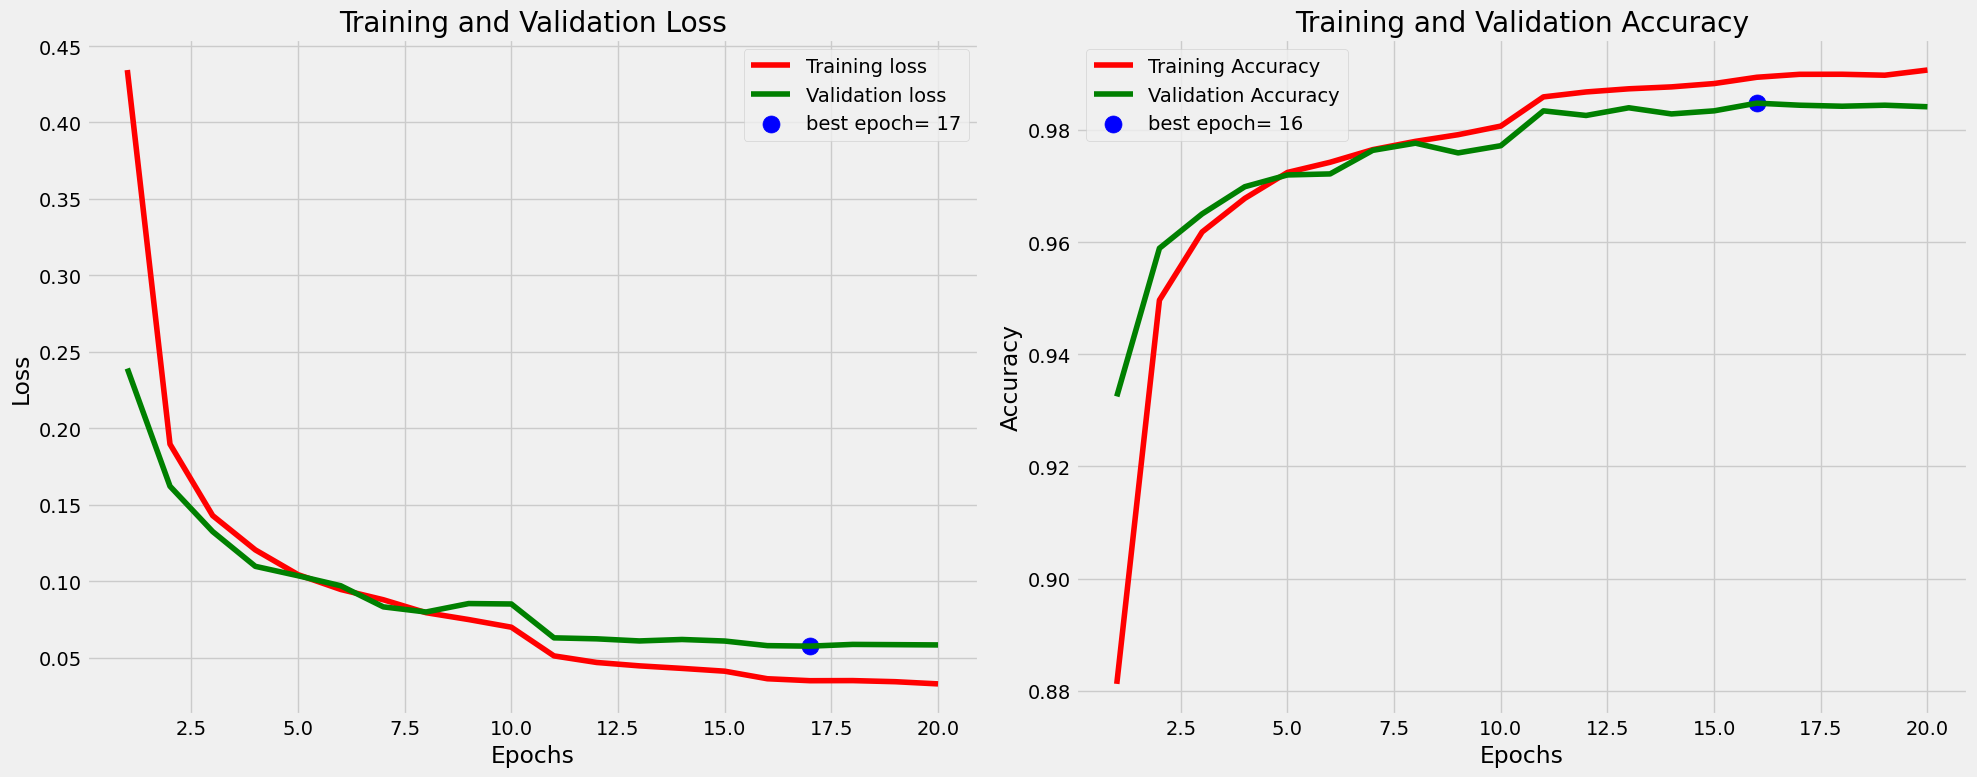

In [ ]:
learning_curves_plot(gru_history, start_epoch=0)

In [ ]:
y_test_pred_gru = gru_model.predict(X_test_new).argmax(axis=1)

343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [ ]:
# Evaluate GRU Model on Test Data
gru_test_loss, gru_test_acc = gru_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"GRU Test Loss: {gru_test_loss:.4f}")
print(f"GRU Test Accuracy: {gru_test_acc:.4f}")

GRU Test Loss: 0.0568
GRU Test Accuracy: 0.9860


In [ ]:
# GRU classification report
print("GRU Classification Report:")
print(classification_report(y_test_new, y_test_pred_gru))

GRU Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9059
         1.0       0.93      0.77      0.84       278
         2.0       0.96      0.96      0.96       724
         3.0       0.82      0.80      0.81        81
         4.0       1.00      0.99      0.99       804

    accuracy                           0.99     10946
   macro avg       0.94      0.90      0.92     10946
weighted avg       0.99      0.99      0.99     10946



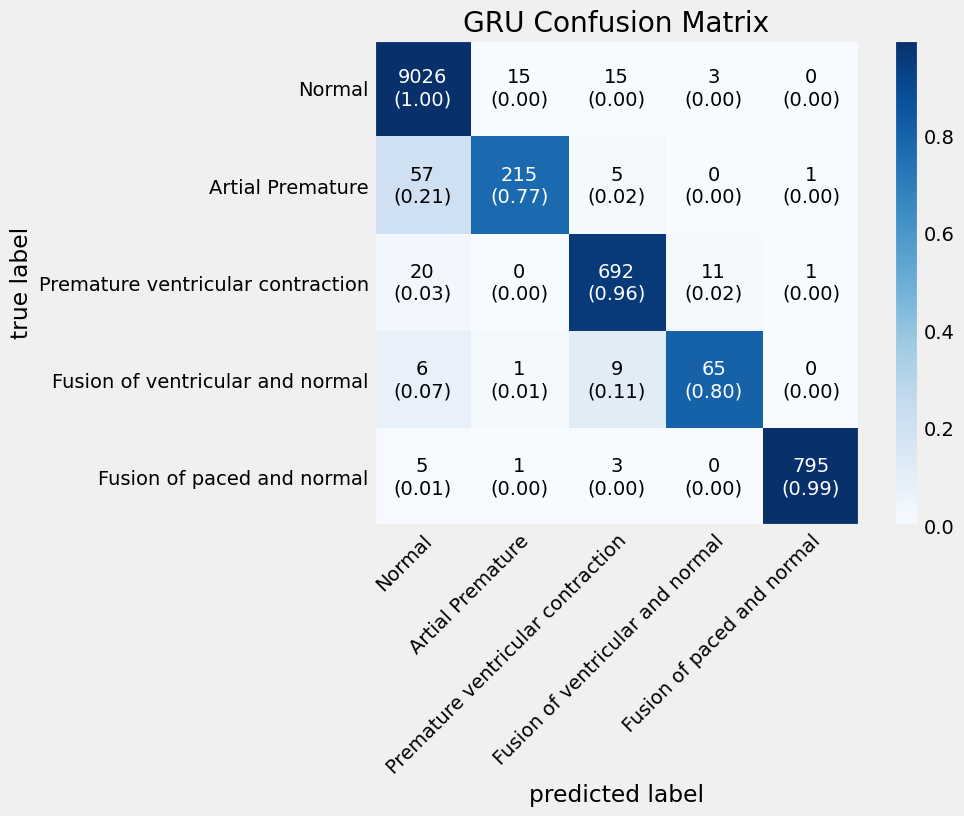

In [ ]:
# Confusion matrix for GRU
conf_matrix_gru = confusion_matrix(y_test_new, y_test_pred_gru)

plot_confusion_matrix(conf_matrix_gru,
                      class_names=class_names,
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.title('GRU Confusion Matrix')
plt.show()

# LSTM

In [ ]:
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))

    return model

In [ ]:
lstm_model = build_lstm_model()

In [ ]:
lstm_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
lstm_history = lstm_model.fit(X_train_scaled, y_train,
                            epochs=20,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks= [reduce_lr, model_checkpoint])

Epoch 1/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.8238 - loss: 0.6573 - val_accuracy: 0.8288 - val_loss: 0.6348 - learning_rate: 0.0010
Epoch 2/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.8366 - loss: 0.5946 - val_accuracy: 0.8976 - val_loss: 0.3757 - learning_rate: 0.0010
Epoch 3/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.9031 - loss: 0.3563 - val_accuracy: 0.9183 - val_loss: 0.2892 - learning_rate: 0.0010
Epoch 4/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.9205 - loss: 0.2834 - val_accuracy: 0.9340 - val_loss: 0.2234 - learning_rate: 0.0010
Epoch 5/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.9339 - loss: 0.2336 - val_accuracy: 0.9314 - val_loss: 0.2477 - learning_rate: 0.0010
Epoch 6/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.9389 - loss: 0.2220 - val_accuracy: 0.9519 - val_loss: 0.1741 - learning_rate: 0.0010
Epoch 7/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accura

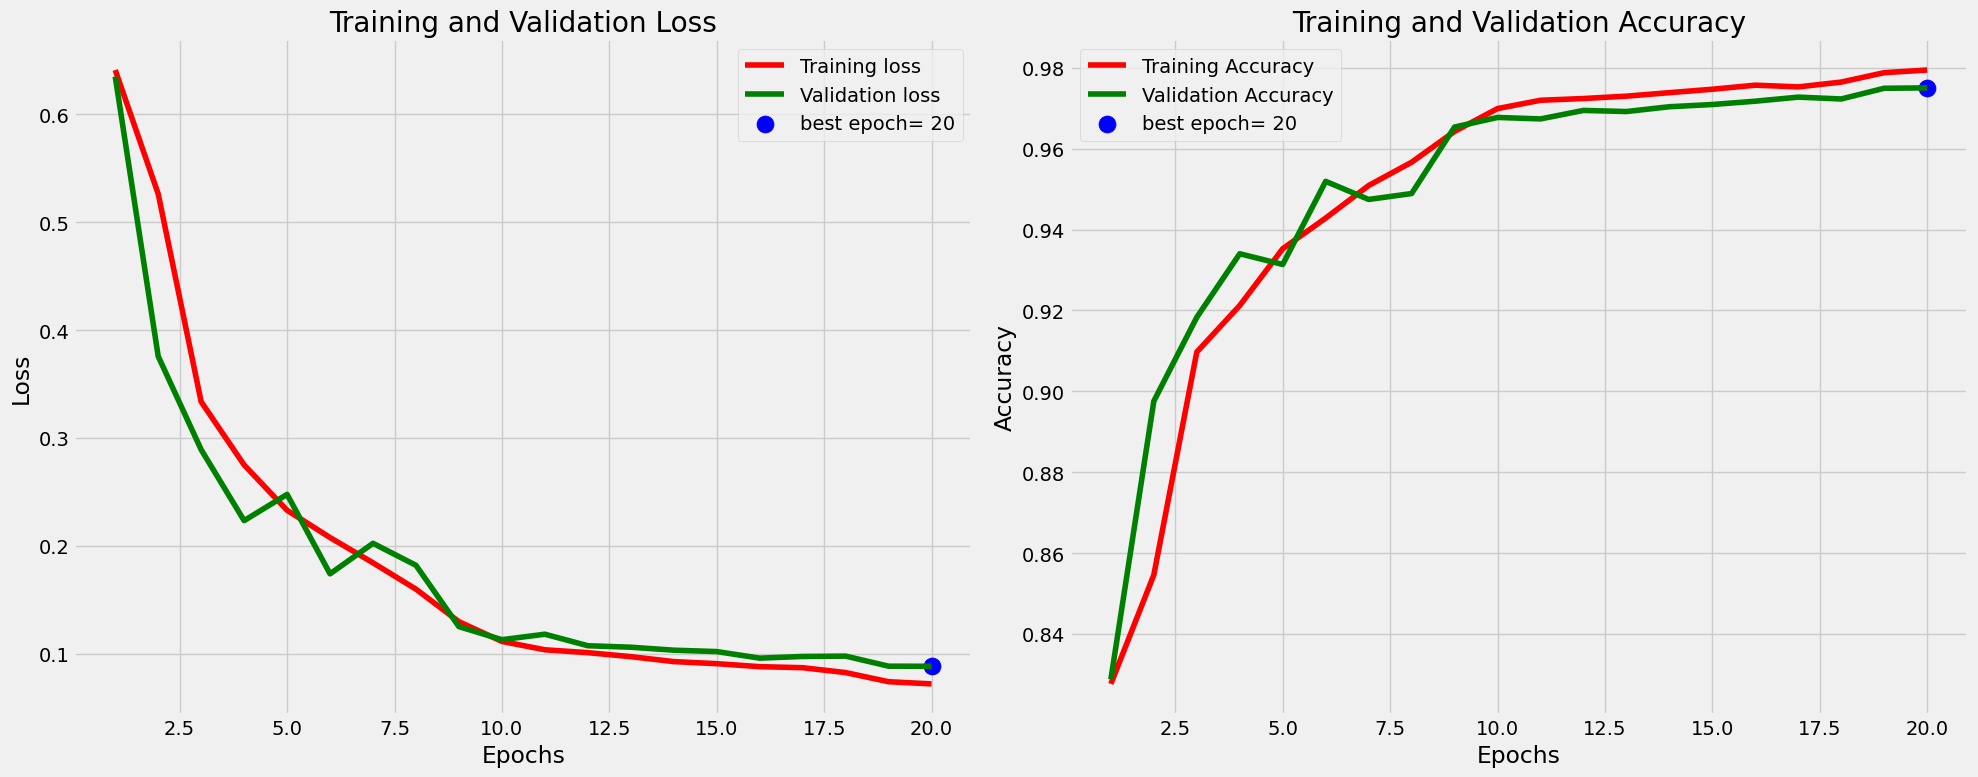

In [ ]:
learning_curves_plot(lstm_history, start_epoch=0)

In [ ]:
y_test_pred_lstm = lstm_model.predict(X_test_new).argmax(axis=1)

343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [ ]:
# Evaluate LSTM Model on Test Data
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"LSTM Test Loss: {lstm_test_loss:.4f}")
print(f"LSTM Test Accuracy: {lstm_test_acc:.4f}")

LSTM Test Loss: 0.0848
LSTM Test Accuracy: 0.9776


In [ ]:
# LSTM classification report
print("LSTM Classification Report:")
print(classification_report(y_test_new, y_test_pred_lstm))

LSTM Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      9059
         1.0       0.90      0.63      0.74       278
         2.0       0.94      0.92      0.93       724
         3.0       0.82      0.74      0.78        81
         4.0       0.99      0.97      0.98       804

    accuracy                           0.98     10946
   macro avg       0.93      0.85      0.88     10946
weighted avg       0.98      0.98      0.98     10946



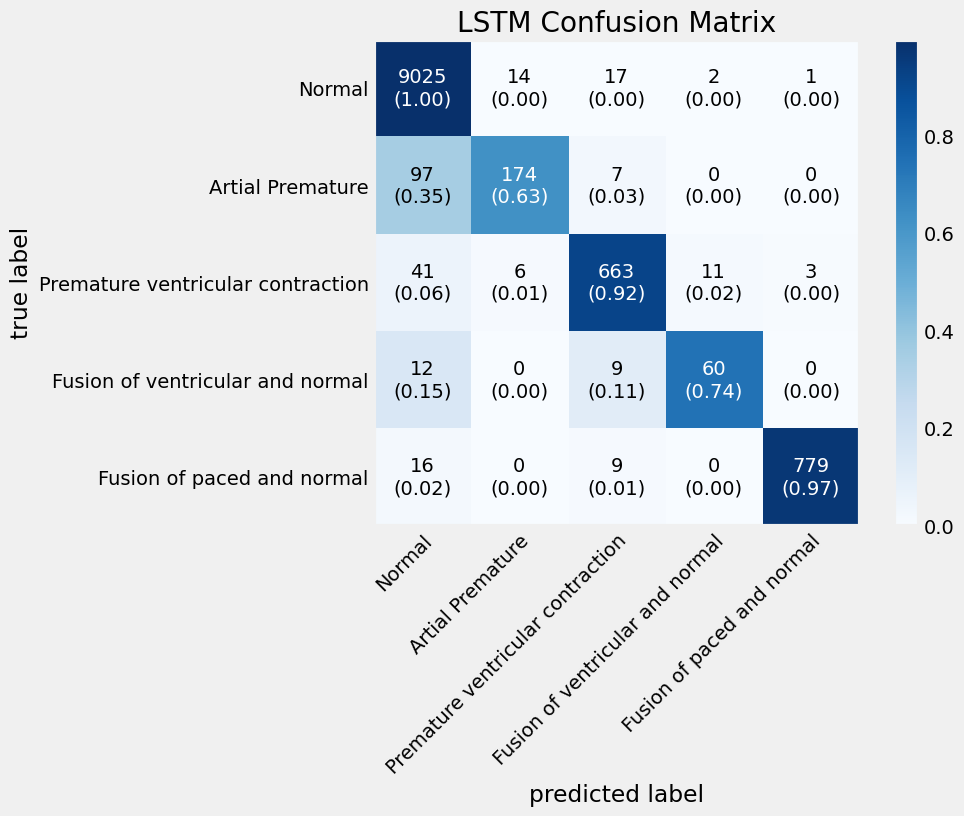

In [ ]:
# Confusion matrix for LSTM
conf_matrix_lstm = confusion_matrix(y_test_new, y_test_pred_lstm)

plot_confusion_matrix(conf_matrix_lstm,
                      class_names=class_names,
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.title('LSTM Confusion Matrix')
plt.show()